<a href="https://colab.research.google.com/github/DarShabi/OCR-Company-Project/blob/main/Week%234/textbox_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get install -q tesseract-ocr
!pip install -q pytesseract Pillow
!pip install -q transformers

Reading package lists...
Building dependency tree...
Reading state information...
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [ ]:
!pip install -q sentencepiece


hi

In [ ]:
from PIL import Image, ImageDraw
from PIL import ImageEnhance, ImageFilter
import pytesseract
from pytesseract import Output
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import torch
import re
from transformers import DonutProcessor, VisionEncoderDecoderModel
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

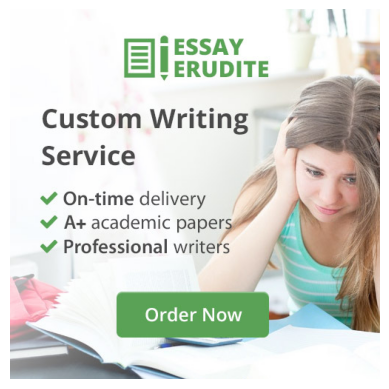

In [ ]:
image_path='/content/38c9b7f0571b5421e78a3226c0d3eee0-2.jpg'
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()


#Finding bounding boxes for text

In [ ]:
def is_inside(box1, box2):
    """Check if box1 is inside box2."""
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    return x1 > x2 and y1 > y2 and x1 + w1 < x2 + w2 and y1 + h1 < y2 + h2

image_path = '/content/38c9b7f0571b5421e78a3226c0d3eee0-2.jpg'
image = Image.open(image_path)
draw = ImageDraw.Draw(image)

# Use Tesseract with a specific Page Segmentation Mode
data = pytesseract.image_to_data(image, config='--psm 11', output_type=Output.DICT)

confidence_threshold = 70  # Confidence threshold
boxes = [(data['left'][i], data['top'][i], data['width'][i], data['height'][i]) for i in range(len(data['text'])) if int(data['conf'][i]) > confidence_threshold]
filtered_boxes = []

# Filter out nested boxes
for box in boxes:
    if not any(is_inside(box, other_box) for other_box in boxes):
        filtered_boxes.append(box)

# Draw filtered bounding boxes on the image
for box in filtered_boxes:
    x, y, w, h = box
    draw.rectangle([x, y, x + w, y + h], outline='red')

# Save the image with filtered bounding boxes
output_path = 'filtered_output_image.jpg'
image.save(output_path)
print(f"Image saved to {output_path}")

Image saved to filtered_output_image.jpg


# TrOCR

In [ ]:
# Initialize the TrOCR model and processor
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-stage1")
trocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-stage1")
trocr_model.eval()

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

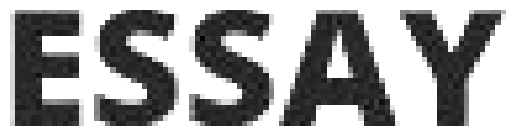

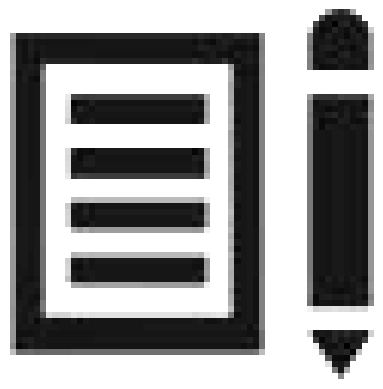

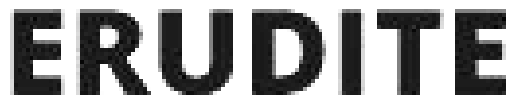

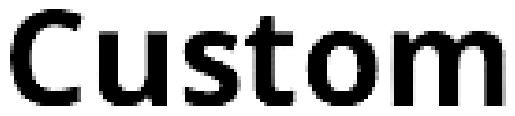

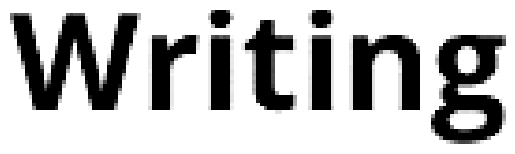

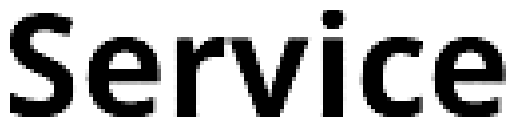

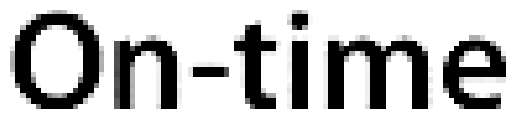

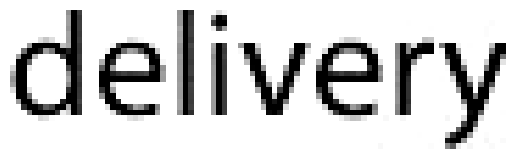

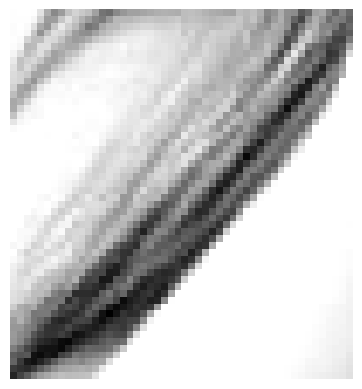

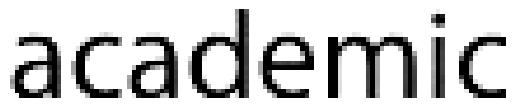

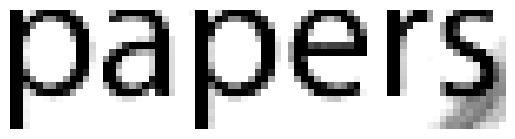

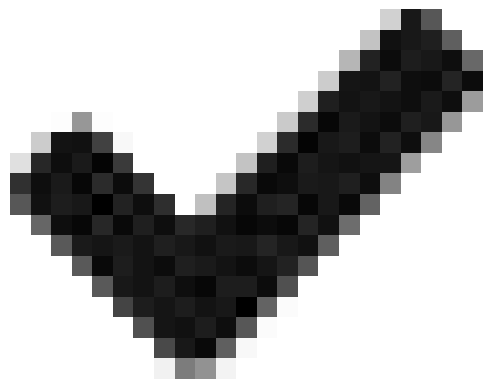

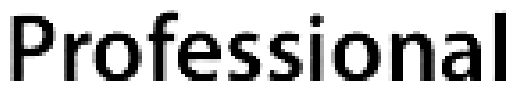

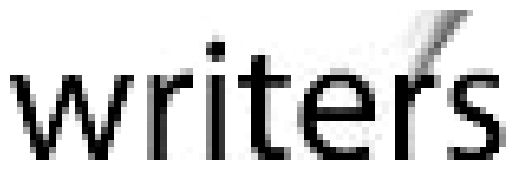

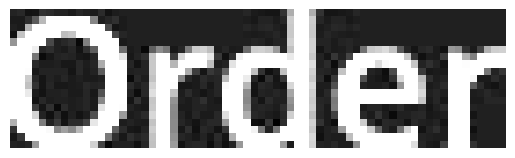

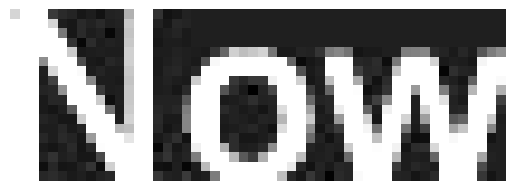

['S', '</s>', 'UR', 'us', 'writing', 'er', 't', 'eli', '</s>', 'cade', 'paper', '</s>', 'o', 'writer', 'Order', 'NOW']


In [ ]:
def boxes_overlap(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    return not (x2 > x1 + w1 or x2 + w2 < x1 or y2 > y1 + h1 or y2 + h2 < y1)

def extract_text_with_trocr(image, boxes):
    texts = []
    for box in boxes:
        x, y, w, h = box
        cropped_image = image.crop((x, y, x + w, y + h))
        cropped_image = cropped_image.convert("L")
        # Apply Gaussian blur for smoothing
        #cropped_image = cropped_image.filter(ImageFilter.GaussianBlur(radius=0.5))
        enhancer = ImageEnhance.Contrast(cropped_image)
        cropped_image = enhancer.enhance(2.0)  # Increase contrast

        # Display the cropped image (text box)
        plt.imshow(cropped_image, cmap='gray')
        plt.axis('off')  # Hide axes
        plt.show()

         # Convert grayscale image to 3-channel format
        cropped_image = Image.merge("RGB", [cropped_image, cropped_image, cropped_image])


        # Process the cropped image and predict text using TrOCR
        inputs = processor(cropped_image, return_tensors="pt")

        # Provide initial input for the decoder using the padding token as the start token
        decoder_input_ids = torch.full((1, 1), processor.tokenizer.pad_token_id, dtype=torch.long)
        outputs = trocr_model(decoder_input_ids=decoder_input_ids, pixel_values=inputs["pixel_values"])

        predicted_text = processor.decode(outputs.logits.argmax(-1)[0])
        texts.append(predicted_text)

    return texts

image=Image.open('/content/38c9b7f0571b5421e78a3226c0d3eee0-2.jpg')
# Extract text from the bounding boxes using TrOCR
texts = extract_text_with_trocr(image, boxes)
print(texts)



#Donut

In [ ]:
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
# load document image

image = Image.open(image_path)

In [ ]:
# prepare decoder inputs
task_prompt = "<s_cord-v2>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

pixel_values = processor(image, return_tensors="pt").pixel_values

outputs = model.generate(
    pixel_values.to(device),
    decoder_input_ids=decoder_input_ids.to(device),
    max_length=model.decoder.config.max_position_embeddings,
    pad_token_id=processor.tokenizer.pad_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
    use_cache=True,
    bad_words_ids=[[processor.tokenizer.unk_token_id]],
    return_dict_in_generate=True,
)

sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
print(processor.token2json(sequence))

{'menu': {'nm': 'ESSAY', 'unitprice': 'ERUDITE', 'cnt': 'Custom Writing', 'price': 'Service'}, 'total': {'total_price': 'On-time delivery', 'creditcardprice': 'A+ academic papers'}}
